In [6]:
%pip install pandas
%pip install matplotlib
%pip install plotly
%pip install scipy
%pip install pillow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation
from scipy.interpolate import interp1d
from PIL import Image

## 1. Import Required Libraries

# Upper Body Skeleton Reconstruction from Apple Vision Pro Data

This notebook implements methods to reconstruct upper body skeletal joints from partial Apple Vision Pro tracking data (head and hands).

**Objectives:**
- Load and visualize existing device pose and hand tracking data
- Implement anthropometric-based joint estimation
- Develop inverse kinematics for elbow positioning
- Visualize the complete upper body skeleton

## 2. Load Vision Pro Data

In [8]:
# Load device pose data (head tracking)
device_data = pd.read_csv('Prototype/Data/device_pose_data .csv')
print(f"Device data shape: {device_data.shape}")
print(f"Columns: {device_data.columns.tolist()}")
device_data.head()

Device data shape: (1514, 9)
Columns: ['t_mono', 't_wall', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']


,t_mono,t_wall,x,y,z,qx,qy,qz,qw
0,0.132681,1.758062e+09,0.040748,0.249334,0.086169,0.045972,0.046942,0.017320,0.997689
1,0.151185,1.758062e+09,0.040800,0.249279,0.086060,0.045745,0.046831,0.017263,0.997705
2,0.168560,1.758062e+09,0.040847,0.249219,0.085955,0.045542,0.046737,0.017195,0.997720
3,0.185886,1.758062e+09,0.040896,0.249151,0.085849,0.045321,0.046643,0.017106,0.997736
4,0.203302,1.758062e+09,0.040936,0.249082,0.085736,0.045068,0.046537,0.017046,0.997754


In [9]:
# Load hand tracking data
hand_data = pd.read_csv('Prototype/Data/hand_data_pivoted.csv')
print(f"Hand data shape: {hand_data.shape}")
print(f"Number of frames: {len(hand_data)}")
print(f"\nSample columns (first 10): {hand_data.columns.tolist()[:10]}")
hand_data.head()

Hand data shape: (4816, 186)
Number of frames: 4816

Sample columns (first 10): ['t_mono', 't_wall', 'chirality', 'thumbKnuckle_px', 'thumbKnuckle_py', 'thumbKnuckle_pz', 'thumbKnuckle_qx', 'thumbKnuckle_qy', 'thumbKnuckle_qz', 'thumbKnuckle_qw']


,t_mono,t_wall,chirality,thumbKnuckle_px,thumbKnuckle_py,thumbKnuckle_pz,thumbKnuckle_qx,thumbKnuckle_qy,thumbKnuckle_qz,thumbKnuckle_qw,...,forearmWrist_qz,forearmWrist_qw,forearmArm_px,forearmArm_py,forearmArm_pz,forearmArm_qx,forearmArm_qy,forearmArm_qz,forearmArm_qw,Unnamed: 185
0,0.208637,1.758062e+09,right,0.243169,0.028552,-0.061662,0.762413,-0.262126,0.070850,0.587365,...,0.068854,0.264537,0.365860,-0.195790,0.026805,0.480577,0.833262,0.068854,0.264537,NaN
1,0.208836,1.758062e+09,left,-0.071502,-0.255476,-0.072477,0.871857,-0.394472,0.053322,-0.285332,...,0.848462,0.000453,-0.208979,-0.205070,0.135211,0.511417,0.136253,0.848462,0.000453,NaN
2,0.220876,1.758062e+09,right,0.215677,0.904898,-0.227673,0.757615,-0.290184,0.109381,0.574324,...,0.092030,0.305965,0.329366,0.680974,-0.127017,0.475552,0.819613,0.092030,0.305965,NaN
3,0.220974,1.758062e+09,left,-0.096416,0.620823,-0.268663,0.868103,-0.380161,0.095424,-0.304581,...,0.872372,0.006818,-0.253408,0.671033,-0.075247,0.469590,0.135666,0.872372,0.006818,NaN
4,0.230773,1.758062e+09,right,0.215550,0.904954,-0.227783,0.757008,-0.290135,0.110900,0.574858,...,0.091746,0.307321,0.329332,0.681425,-0.126355,0.474536,0.819727,0.091746,0.307321,NaN


## 3. Extract Key Joint Data

Extract the important joints we have: head, wrists, and forearm positions.

In [10]:
def extract_joint_positions(hand_df, joint_name, chirality='right'):
    """Extract position and orientation for a specific joint."""
    filtered = hand_df[hand_df['chirality'] == chirality]
    
    position = filtered[[f'{joint_name}_px', f'{joint_name}_py', f'{joint_name}_pz']].values
    orientation = filtered[[f'{joint_name}_qx', f'{joint_name}_qy', f'{joint_name}_qz', f'{joint_name}_qw']].values
    
    return position, orientation

# Extract wrist and forearm positions for both hands
right_wrist_pos, right_wrist_ori = extract_joint_positions(hand_data, 'forearmWrist', 'right')
left_wrist_pos, left_wrist_ori = extract_joint_positions(hand_data, 'forearmWrist', 'left')

right_forearm_pos, right_forearm_ori = extract_joint_positions(hand_data, 'forearmArm', 'right')
left_forearm_pos, left_forearm_ori = extract_joint_positions(hand_data, 'forearmArm', 'left')

print(f"Right wrist positions: {right_wrist_pos.shape}")
print(f"Left wrist positions: {left_wrist_pos.shape}")
print(f"Right forearm positions: {right_forearm_pos.shape}")
print(f"Left forearm positions: {left_forearm_pos.shape}")

Right wrist positions: (2415, 3)
Left wrist positions: (2401, 3)
Right forearm positions: (2415, 3)
Left forearm positions: (2401, 3)


In [14]:
# Extract head positions and orientations with proper bounds handling
head_positions_raw = device_data[['x', 'y', 'z']].values
head_orientations_raw = device_data[['qx', 'qy', 'qz', 'qw']].values
head_timestamps = device_data['t_mono'].values

print(f"Raw head positions: {head_positions_raw.shape}")
print(f"Raw head orientations: {head_orientations_raw.shape}")

# Get hand timestamps for interpolation target
hand_timestamps = hand_data[hand_data['chirality'] == 'right']['t_mono'].values
target_frame_count = len(hand_timestamps)

print(f"\nTarget frame count (from hand data): {target_frame_count}")
print(f"Head data frames: {len(head_positions_raw)}")
print(f"Frame count ratio: {target_frame_count / len(head_positions_raw):.2f}x")

# Find the overlapping time range
head_min_time = head_timestamps.min()
head_max_time = head_timestamps.max()
hand_min_time = hand_timestamps.min()
hand_max_time = hand_timestamps.max()

print(f"\nHead timestamp range: [{head_min_time:.3f}, {head_max_time:.3f}]")
print(f"Hand timestamp range: [{hand_min_time:.3f}, {hand_max_time:.3f}]")

# Clip hand timestamps to be within head timestamp range
hand_timestamps_clipped = np.clip(hand_timestamps, head_min_time, head_max_time)

# Find which hand frames are within the valid range
valid_mask = (hand_timestamps >= head_min_time) & (hand_timestamps <= head_max_time)
num_valid = valid_mask.sum()
print(f"\nValid hand frames within head range: {num_valid}/{len(hand_timestamps)}")

# Interpolate head positions
print("\nInterpolating head positions to match hand data frame rate...")
head_positions = np.zeros((target_frame_count, 3))
for i in range(3):  # x, y, z
    interp_func = interp1d(head_timestamps, head_positions_raw[:, i], 
                          kind='cubic', 
                          bounds_error=False, 
                          fill_value='extrapolate')
    head_positions[:, i] = interp_func(hand_timestamps_clipped)

# Interpolate head orientations using SLERP
print("Interpolating head orientations using SLERP...")
rotations = Rotation.from_quat(head_orientations_raw)

# Create Slerp interpolator
from scipy.spatial.transform import Slerp
slerp_interp = Slerp(head_timestamps, rotations)

# Interpolate only within valid range
interpolated_rotations = slerp_interp(hand_timestamps_clipped)
head_orientations = interpolated_rotations.as_quat()

print(f"\nInterpolated head positions: {head_positions.shape}")
print(f"Interpolated head orientations: {head_orientations.shape}")
print(f"Sample head position: {head_positions[0]}")
print(f"Sample head orientation (quaternion): {head_orientations[0]}")

# Also filter the hand data to only use valid frames if needed
if not valid_mask.all():
    print(f"\n⚠️  Warning: {(~valid_mask).sum()} hand frames are outside head tracking range")
    print("These frames will use extrapolated head data (may be less accurate)")

Raw head positions: (1514, 3)
Raw head orientations: (1514, 4)

Target frame count (from hand data): 2415
Head data frames: 1514
Frame count ratio: 1.60x

Head timestamp range: [0.133, 27.147]
Hand timestamp range: [0.209, 27.153]

Valid hand frames within head range: 2414/2415

Interpolating head positions to match hand data frame rate...
Interpolating head orientations using SLERP...

Interpolated head positions: (2415, 3)
Interpolated head orientations: (2415, 4)
Sample head position: [0.02962596 0.49307313 0.03387046]
Sample head orientation (quaternion): [0.04472287 0.03166356 0.01770498 0.99834053]

⚠️  Warning: 1 hand frames are outside head tracking range
These frames will use extrapolated head data (may be less accurate)


## 4. Visualize Existing Data

Visualize the raw data we have: head position and hand joints.

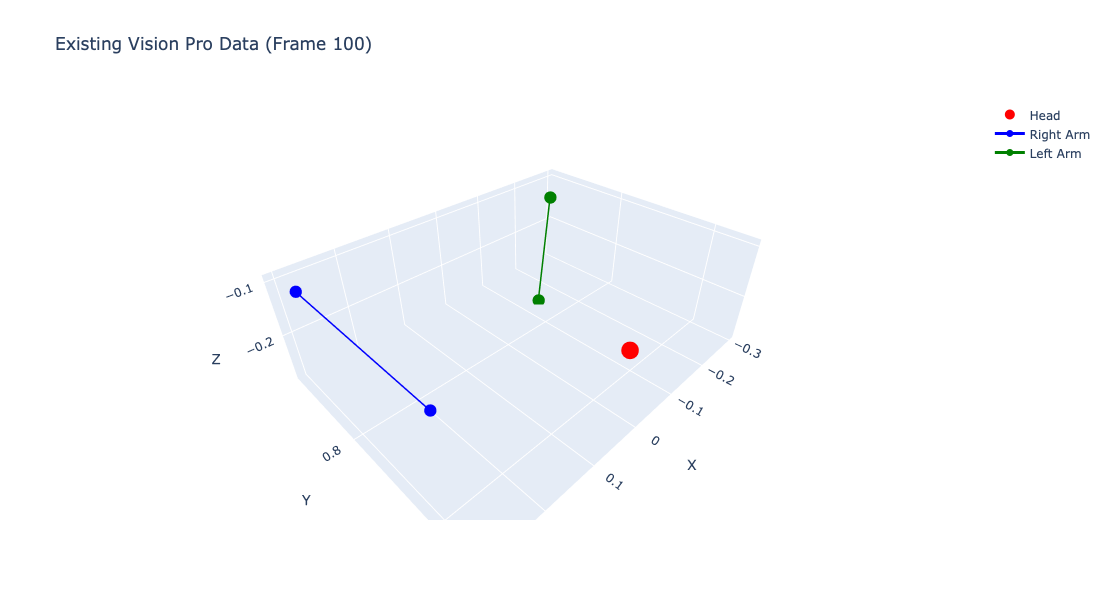

In [15]:
# Visualize a single frame of existing data
frame_idx = 100  # Choose a frame to visualize

fig = go.Figure()

# Add head position
fig.add_trace(go.Scatter3d(
    x=[head_positions[frame_idx, 0]],
    y=[head_positions[frame_idx, 1]],
    z=[head_positions[frame_idx, 2]],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Head'
))

# Add right hand joints
fig.add_trace(go.Scatter3d(
    x=[right_wrist_pos[frame_idx, 0], right_forearm_pos[frame_idx, 0]],
    y=[right_wrist_pos[frame_idx, 1], right_forearm_pos[frame_idx, 1]],
    z=[right_wrist_pos[frame_idx, 2], right_forearm_pos[frame_idx, 2]],
    mode='markers+lines',
    marker=dict(size=7, color='blue'),
    line=dict(color='blue', width=3),
    name='Right Arm'
))

# Add left hand joints
fig.add_trace(go.Scatter3d(
    x=[left_wrist_pos[frame_idx, 0], left_forearm_pos[frame_idx, 0]],
    y=[left_wrist_pos[frame_idx, 1], left_forearm_pos[frame_idx, 1]],
    z=[left_wrist_pos[frame_idx, 2], left_forearm_pos[frame_idx, 2]],
    mode='markers+lines',
    marker=dict(size=7, color='green'),
    line=dict(color='green', width=3),
    name='Left Arm'
))

fig.update_layout(
    title=f'Existing Vision Pro Data (Frame {frame_idx})',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    width=800,
    height=600
)

fig.show()

## 5. Define Anthropometric Parameters

Set up body proportions based on user height.

In [16]:
class AnthropometricModel:
    """
    Anthropometric body proportions based on user height.
    Standard ratios from biomechanical literature.
    """
    def __init__(self, height_m=1.75):
        self.height = height_m
        
        # Body segment lengths as percentages of height
        self.neck_length = 0.05 * height_m          # 5% of height
        self.shoulder_width = 0.25 * height_m       # 25% of height
        self.upper_arm_length = 0.18 * height_m     # 18% of height
        self.forearm_length = 0.16 * height_m       # 16% of height
        self.spine_length = 0.30 * height_m         # 30% of height (total)
        
        # Spine segments (divide total spine into 3 segments)
        self.upper_spine_length = 0.10 * height_m
        self.mid_spine_length = 0.10 * height_m
        self.lower_spine_length = 0.10 * height_m
        
    def __repr__(self):
        return f"""AnthropometricModel(height={self.height}m)
  Neck: {self.neck_length:.3f}m
  Shoulder width: {self.shoulder_width:.3f}m
  Upper arm: {self.upper_arm_length:.3f}m
  Forearm: {self.forearm_length:.3f}m
  Spine: {self.spine_length:.3f}m"""

# Create model (user can input their height)
USER_HEIGHT = 1.75  # meters (adjust as needed)
body_model = AnthropometricModel(USER_HEIGHT)
print(body_model)

AnthropometricModel(height=1.75m)
  Neck: 0.088m
  Shoulder width: 0.438m
  Upper arm: 0.315m
  Forearm: 0.280m
  Spine: 0.525m


## 6. Implement Joint Estimation Methods

Methods to estimate missing joints (neck, shoulders, spine, elbows).

In [17]:
def quaternion_to_rotation_matrix(q):
    """Convert quaternion [qx, qy, qz, qw] to rotation matrix."""
    qx, qy, qz, qw = q
    return np.array([
        [1 - 2*(qy**2 + qz**2), 2*(qx*qy - qz*qw), 2*(qx*qz + qy*qw)],
        [2*(qx*qy + qz*qw), 1 - 2*(qx**2 + qz**2), 2*(qy*qz - qx*qw)],
        [2*(qx*qz - qy*qw), 2*(qy*qz + qx*qw), 1 - 2*(qx**2 + qy**2)]
    ])

def get_down_vector(head_quaternion):
    """Get the downward direction vector from head orientation."""
    rot_matrix = quaternion_to_rotation_matrix(head_quaternion)
    # Down vector is negative Y in local frame
    down_vector = -rot_matrix[:, 1]
    return down_vector / np.linalg.norm(down_vector)

# Test the functions
test_quat = head_orientations[100]
down = get_down_vector(test_quat)
print(f"Test head quaternion: {test_quat}")
print(f"Down vector: {down}")

Test head quaternion: [-0.25042309 -0.00850102 -0.068528    0.96567071]
Down vector: [-0.13660866 -0.86518438  0.48248737]


In [18]:
def estimate_neck_position(head_pos, head_quat, body_model):
    """Estimate neck position as offset below head."""
    down_vector = get_down_vector(head_quat)
    neck_pos = head_pos + down_vector * body_model.neck_length
    return neck_pos

def estimate_spine_positions(neck_pos, head_quat, body_model):
    """Estimate upper, mid, and lower spine positions."""
    down_vector = get_down_vector(head_quat)
    
    upper_spine = neck_pos + down_vector * body_model.upper_spine_length
    mid_spine = upper_spine + down_vector * body_model.mid_spine_length
    lower_spine = mid_spine + down_vector * body_model.lower_spine_length
    
    return upper_spine, mid_spine, lower_spine

# Test on a single frame
test_frame = 100
test_neck = estimate_neck_position(head_positions[test_frame], head_orientations[test_frame], body_model)
test_spines = estimate_spine_positions(test_neck, head_orientations[test_frame], body_model)

print(f"Head position: {head_positions[test_frame]}")
print(f"Estimated neck: {test_neck}")
print(f"Estimated upper spine: {test_spines[0]}")
print(f"Estimated mid spine: {test_spines[1]}")
print(f"Estimated lower spine: {test_spines[2]}")

Head position: [ 0.02715789  1.06727942 -0.13187575]
Estimated neck: [ 0.01520463  0.99157579 -0.08965811]
Estimated upper spine: [-0.00870188  0.84016853 -0.00522282]
Estimated mid spine: [-0.0326084   0.68876126  0.07921247]
Estimated lower spine: [-0.05651491  0.53735399  0.16364777]


In [19]:
def estimate_shoulder_positions(upper_spine_pos, head_quat, body_model):
    """Estimate left and right shoulder positions."""
    rot_matrix = quaternion_to_rotation_matrix(head_quat)
    # Right vector in local frame
    right_vector = rot_matrix[:, 0]
    right_vector = right_vector / np.linalg.norm(right_vector)
    
    # Shoulders are at shoulder width apart
    left_shoulder = upper_spine_pos - right_vector * (body_model.shoulder_width / 2)
    right_shoulder = upper_spine_pos + right_vector * (body_model.shoulder_width / 2)
    
    return left_shoulder, right_shoulder

# Test shoulder estimation
test_upper_spine = test_spines[0]
test_left_shoulder, test_right_shoulder = estimate_shoulder_positions(
    test_upper_spine, head_orientations[test_frame], body_model
)

print(f"Upper spine: {test_upper_spine}")
print(f"Left shoulder: {test_left_shoulder}")
print(f"Right shoulder: {test_right_shoulder}")
print(f"Shoulder distance: {np.linalg.norm(test_right_shoulder - test_left_shoulder):.3f}m")

Upper spine: [-0.00870188  0.84016853 -0.00522282]
Left shoulder: [-0.22536573  0.86818893 -0.01632227]
Right shoulder: [0.20796196 0.81214813 0.00587664]
Shoulder distance: 0.438m


## 7. Implement Elbow IK with Three-Point Constraint

Use shoulder (estimated), forearm (known), and wrist (known) to solve for elbow position.

In [20]:
def estimate_elbow_position(shoulder_pos, forearm_pos, wrist_pos, upper_arm_length):
    """
    Estimate elbow position using three constraint points.
    
    Strategy:
    - Elbow should be between shoulder and forearm joint
    - Distance from shoulder to elbow = upper_arm_length
    - Elbow positioned along the shoulder-to-forearm direction
    """
    # Direction from shoulder to forearm
    shoulder_to_forearm = forearm_pos - shoulder_pos
    distance_to_forearm = np.linalg.norm(shoulder_to_forearm)
    
    if distance_to_forearm < upper_arm_length:
        # Forearm is closer than upper arm length - place elbow proportionally
        direction = shoulder_to_forearm / distance_to_forearm
        elbow_pos = shoulder_pos + direction * upper_arm_length
    else:
        # Normal case - place elbow at upper arm length along the direction
        direction = shoulder_to_forearm / distance_to_forearm
        elbow_pos = shoulder_pos + direction * upper_arm_length
    
    return elbow_pos

# Test elbow estimation
test_right_elbow = estimate_elbow_position(
    test_right_shoulder,
    right_forearm_pos[test_frame],
    right_wrist_pos[test_frame],
    body_model.upper_arm_length
)

test_left_elbow = estimate_elbow_position(
    test_left_shoulder,
    left_forearm_pos[test_frame],
    left_wrist_pos[test_frame],
    body_model.upper_arm_length
)

print(f"Right elbow: {test_right_elbow}")
print(f"Distance shoulder to elbow: {np.linalg.norm(test_right_elbow - test_right_shoulder):.3f}m")
print(f"\nLeft elbow: {test_left_elbow}")
print(f"Distance shoulder to elbow: {np.linalg.norm(test_left_elbow - test_left_shoulder):.3f}m")

Right elbow: [ 0.35659394  0.5907232  -0.16176744]
Distance shoulder to elbow: 0.315m

Left elbow: [-0.30237278  0.59790935 -0.15860321]
Distance shoulder to elbow: 0.315m


## 8. Complete Skeleton Reconstruction

Combine all estimation methods into a complete skeleton reconstruction function.

In [21]:
class UpperBodySkeleton:
    """Complete upper body skeleton with all joints."""
    def __init__(self):
        self.head = None
        self.neck = None
        self.upper_spine = None
        self.mid_spine = None
        self.lower_spine = None
        self.left_shoulder = None
        self.right_shoulder = None
        self.left_elbow = None
        self.right_elbow = None
        self.left_wrist = None
        self.right_wrist = None
        self.left_forearm = None
        self.right_forearm = None
    
    def get_all_joints(self):
        """Return dictionary of all joint positions."""
        return {
            'head': self.head,
            'neck': self.neck,
            'upper_spine': self.upper_spine,
            'mid_spine': self.mid_spine,
            'lower_spine': self.lower_spine,
            'left_shoulder': self.left_shoulder,
            'right_shoulder': self.right_shoulder,
            'left_elbow': self.left_elbow,
            'right_elbow': self.right_elbow,
            'left_wrist': self.left_wrist,
            'right_wrist': self.right_wrist,
        }

def reconstruct_skeleton(frame_idx, head_pos, head_quat, 
                         left_wrist, right_wrist,
                         left_forearm, right_forearm,
                         body_model):
    """
    Reconstruct complete upper body skeleton for a single frame.
    """
    skeleton = UpperBodySkeleton()
    
    # Known joints
    skeleton.head = head_pos
    skeleton.left_wrist = left_wrist
    skeleton.right_wrist = right_wrist
    skeleton.left_forearm = left_forearm
    skeleton.right_forearm = right_forearm
    
    # Estimate hardcoded joints
    skeleton.neck = estimate_neck_position(head_pos, head_quat, body_model)
    upper, mid, lower = estimate_spine_positions(skeleton.neck, head_quat, body_model)
    skeleton.upper_spine = upper
    skeleton.mid_spine = mid
    skeleton.lower_spine = lower
    
    # Estimate shoulders
    skeleton.left_shoulder, skeleton.right_shoulder = estimate_shoulder_positions(
        skeleton.upper_spine, head_quat, body_model
    )
    
    # Estimate elbows using IK
    skeleton.left_elbow = estimate_elbow_position(
        skeleton.left_shoulder, left_forearm, left_wrist, body_model.upper_arm_length
    )
    skeleton.right_elbow = estimate_elbow_position(
        skeleton.right_shoulder, right_forearm, right_wrist, body_model.upper_arm_length
    )
    
    return skeleton

# Test complete reconstruction
test_skeleton = reconstruct_skeleton(
    test_frame,
    head_positions[test_frame],
    head_orientations[test_frame],
    left_wrist_pos[test_frame],
    right_wrist_pos[test_frame],
    left_forearm_pos[test_frame],
    right_forearm_pos[test_frame],
    body_model
)

print("Reconstructed skeleton joints:")
for joint_name, joint_pos in test_skeleton.get_all_joints().items():
    if joint_pos is not None:
        print(f"  {joint_name}: {joint_pos}")

Reconstructed skeleton joints:
  head: [ 0.02715789  1.06727942 -0.13187575]
  neck: [ 0.01520463  0.99157579 -0.08965811]
  upper_spine: [-0.00870188  0.84016853 -0.00522282]
  mid_spine: [-0.0326084   0.68876126  0.07921247]
  lower_spine: [-0.05651491  0.53735399  0.16364777]
  left_shoulder: [-0.22536573  0.86818893 -0.01632227]
  right_shoulder: [0.20796196 0.81214813 0.00587664]
  left_elbow: [-0.30237278  0.59790935 -0.15860321]
  right_elbow: [ 0.35659394  0.5907232  -0.16176744]
  left_wrist: [-0.13726911  0.7446337  -0.28581917]
  right_wrist: [ 0.21824683  0.8634487  -0.2548641 ]


## 9. Visualize Complete Reconstructed Skeleton

Visualize the complete upper body skeleton with both known and estimated joints.

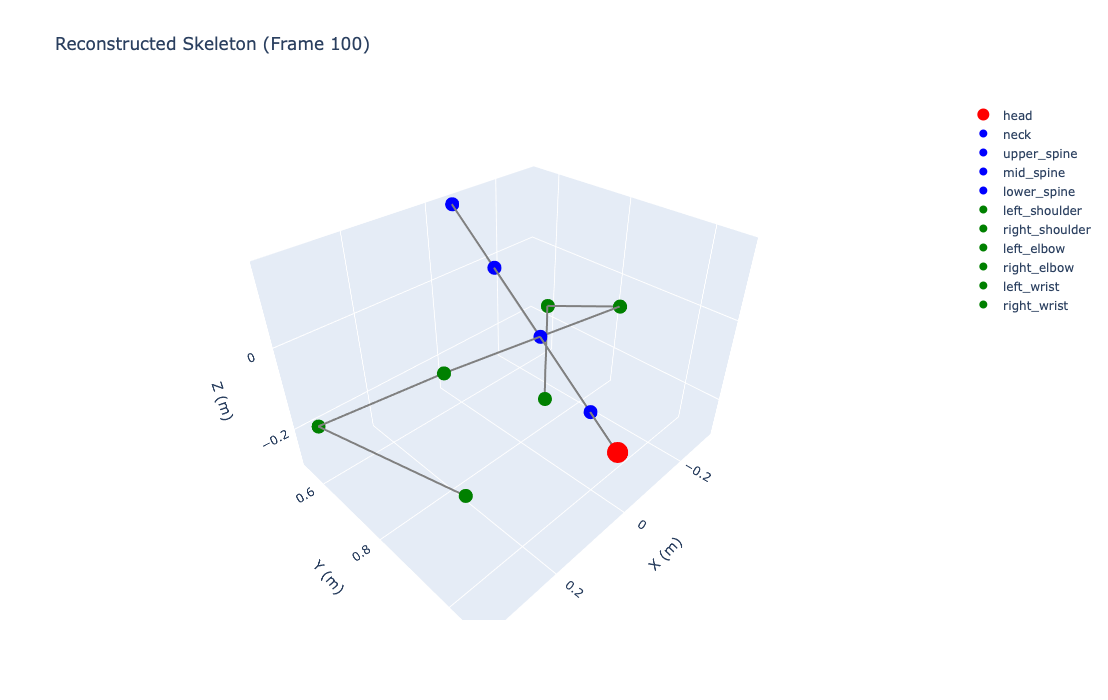

In [23]:
def visualize_skeleton(skeleton, title="Upper Body Skeleton"):
    """
    Visualize the complete skeleton with connections.
    """
    fig = go.Figure()
    
    joints = skeleton.get_all_joints()
    
    # Define skeleton connections (bones)
    connections = [
        ('head', 'neck'),
        ('neck', 'upper_spine'),
        ('upper_spine', 'mid_spine'),
        ('mid_spine', 'lower_spine'),
        ('upper_spine', 'left_shoulder'),
        ('upper_spine', 'right_shoulder'),
        ('left_shoulder', 'left_elbow'),
        ('left_elbow', 'left_wrist'),
        ('right_shoulder', 'right_elbow'),
        ('right_elbow', 'right_wrist'),
    ]
    
    # Plot bones as lines
    for start_joint, end_joint in connections:
        if joints[start_joint] is not None and joints[end_joint] is not None:
            start_pos = joints[start_joint]
            end_pos = joints[end_joint]
            
            fig.add_trace(go.Scatter3d(
                x=[start_pos[0], end_pos[0]],
                y=[start_pos[1], end_pos[1]],
                z=[start_pos[2], end_pos[2]],
                mode='lines',
                line=dict(color='gray', width=4),
                showlegend=False
            ))
    
    # Plot joints as markers
    for joint_name, joint_pos in joints.items():
        if joint_pos is not None:
            # Color code: red for head, blue for spine, green for arms
            if 'head' in joint_name:
                color = 'red'
                size = 12
            elif 'spine' in joint_name or 'neck' in joint_name:
                color = 'blue'
                size = 8
            else:
                color = 'green'
                size = 8
            
            fig.add_trace(go.Scatter3d(
                x=[joint_pos[0]],
                y=[joint_pos[1]],
                z=[joint_pos[2]],
                mode='markers',
                marker=dict(size=size, color=color),
                name=joint_name
            ))
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title='Z (m)',
            aspectmode='data'
        ),
        width=900,
        height=700
    )
    
    return fig

# Visualize the reconstructed skeleton
fig = visualize_skeleton(test_skeleton, f"Reconstructed Skeleton (Frame {test_frame})")
fig.show()

## 10. Single Frame Analysis

Focus on reconstructing and analyzing a single frame.

In [ ]:
# Select a frame to analyze
test_frame = 100

# Reconstruct skeleton for this single frame
print(f"Reconstructing skeleton for frame {test_frame}...")
single_skeleton = reconstruct_skeleton(
    test_frame,
    head_positions[test_frame],
    head_orientations[test_frame],
    left_wrist_pos[test_frame],
    right_wrist_pos[test_frame],
    left_forearm_pos[test_frame],
    right_forearm_pos[test_frame],
    body_model
)

print("\nReconstruction complete!")
print("\nJoint positions:")
joints = single_skeleton.get_all_joints()
for joint_name, joint_pos in joints.items():
    if joint_pos is not None:
        print(f"  {joint_name}: [{joint_pos[0]:.3f}, {joint_pos[1]:.3f}, {joint_pos[2]:.3f}]")

## 11. Validate Single Frame Results

Check bone lengths and joint positions for the reconstructed frame.

In [ ]:
def validate_skeleton(skeleton, body_model):
    """
    Validate skeleton measurements against expected bone lengths.
    """
    results = {}
    
    # Check upper arm lengths
    if skeleton.left_shoulder is not None and skeleton.left_elbow is not None:
        left_upper_arm = np.linalg.norm(skeleton.left_elbow - skeleton.left_shoulder)
        results['left_upper_arm'] = left_upper_arm
    
    if skeleton.right_shoulder is not None and skeleton.right_elbow is not None:
        right_upper_arm = np.linalg.norm(skeleton.right_elbow - skeleton.right_shoulder)
        results['right_upper_arm'] = right_upper_arm
    
    # Check shoulder width
    if skeleton.left_shoulder is not None and skeleton.right_shoulder is not None:
        shoulder_width = np.linalg.norm(skeleton.right_shoulder - skeleton.left_shoulder)
        results['shoulder_width'] = shoulder_width
    
    # Check neck length
    if skeleton.head is not None and skeleton.neck is not None:
        neck_length = np.linalg.norm(skeleton.neck - skeleton.head)
        results['neck_length'] = neck_length
    
    return results

# Validate the reconstructed skeleton
print("Validation Results for Frame", test_frame)
print("=" * 50)
print(f"\nExpected measurements (from anthropometric model):")
print(f"  Upper arm length: {body_model.upper_arm_length:.3f}m")
print(f"  Shoulder width: {body_model.shoulder_width:.3f}m")
print(f"  Neck length: {body_model.neck_length:.3f}m")

measurements = validate_skeleton(single_skeleton, body_model)
print(f"\nActual measurements:")
for key, value in measurements.items():
    print(f"  {key}: {value:.3f}m")

# Calculate errors
print(f"\nMeasurement errors:")
if 'left_upper_arm' in measurements:
    error = abs(measurements['left_upper_arm'] - body_model.upper_arm_length)
    print(f"  Left upper arm error: {error:.3f}m ({error/body_model.upper_arm_length*100:.1f}%)")
if 'right_upper_arm' in measurements:
    error = abs(measurements['right_upper_arm'] - body_model.upper_arm_length)
    print(f"  Right upper arm error: {error:.3f}m ({error/body_model.upper_arm_length*100:.1f}%)")
if 'shoulder_width' in measurements:
    error = abs(measurements['shoulder_width'] - body_model.shoulder_width)
    print(f"  Shoulder width error: {error:.3f}m ({error/body_model.shoulder_width*100:.1f}%)")
if 'neck_length' in measurements:
    error = abs(measurements['neck_length'] - body_model.neck_length)
    print(f"  Neck length error: {error:.3f}m ({error/body_model.neck_length*100:.1f}%)")

## 13. Interactive Slider Visualization

Create an interactive Plotly visualization with a slider to scrub through all frames.

In [ ]:
def create_interactive_skeleton_viewer(head_positions, head_orientations,
                                      left_wrist_pos, right_wrist_pos,
                                      left_forearm_pos, right_forearm_pos,
                                      body_model, step=1):
    """
    Create an interactive Plotly figure with slider to view skeleton across all frames.
    
    Args:
        step: Frame step size (use higher values for faster loading with many frames)
    """
    # Determine the minimum frame count across all data sources
    num_frames = min(len(head_positions), len(left_wrist_pos), len(right_wrist_pos),
                     len(left_forearm_pos), len(right_forearm_pos))
    frame_indices = list(range(0, num_frames, step))
    
    print(f"Creating interactive viewer for {len(frame_indices)} frames (every {step} frame(s))...")
    print(f"Total frames available: {num_frames}")
    
    # Pre-compute all skeletons
    skeletons = []
    for idx in frame_indices:
        skeleton = reconstruct_skeleton(
            idx,
            head_positions[idx],
            head_orientations[idx],
            left_wrist_pos[idx],
            right_wrist_pos[idx],
            left_forearm_pos[idx],
            right_forearm_pos[idx],
            body_model
        )
        skeletons.append(skeleton)
    
    # Define skeleton connections (bones)
    connections = [
        ('head', 'neck'),
        ('neck', 'upper_spine'),
        ('upper_spine', 'mid_spine'),
        ('mid_spine', 'lower_spine'),
        ('upper_spine', 'left_shoulder'),
        ('upper_spine', 'right_shoulder'),
        ('left_shoulder', 'left_elbow'),
        ('left_elbow', 'left_wrist'),
        ('right_shoulder', 'right_elbow'),
        ('right_elbow', 'right_wrist'),
    ]
    
    # Create figure
    fig = go.Figure()
    
    # Add traces for the first frame
    skeleton = skeletons[0]
    joints = skeleton.get_all_joints()
    
    # Add bone lines
    for start_joint, end_joint in connections:
        if joints[start_joint] is not None and joints[end_joint] is not None:
            start_pos = joints[start_joint]
            end_pos = joints[end_joint]
            
            fig.add_trace(go.Scatter3d(
                x=[start_pos[0], end_pos[0]],
                y=[start_pos[1], end_pos[1]],
                z=[start_pos[2], end_pos[2]],
                mode='lines',
                line=dict(color='gray', width=4),
                showlegend=False,
                name=f'{start_joint}-{end_joint}'
            ))
    
    # Add joint markers
    for joint_name, joint_pos in joints.items():
        if joint_pos is not None:
            # Color code: red for head, blue for spine, green for arms
            if 'head' in joint_name:
                color = 'red'
                size = 12
            elif 'spine' in joint_name or 'neck' in joint_name:
                color = 'blue'
                size = 8
            else:
                color = 'green'
                size = 8
            
            fig.add_trace(go.Scatter3d(
                x=[joint_pos[0]],
                y=[joint_pos[1]],
                z=[joint_pos[2]],
                mode='markers',
                marker=dict(size=size, color=color),
                name=joint_name
            ))
    
    # Create frames for animation
    frames = []
    for i, (frame_idx, skeleton) in enumerate(zip(frame_indices, skeletons)):
        joints = skeleton.get_all_joints()
        
        frame_data = []
        
        # Add bone lines for this frame
        for start_joint, end_joint in connections:
            if joints[start_joint] is not None and joints[end_joint] is not None:
                start_pos = joints[start_joint]
                end_pos = joints[end_joint]
                
                frame_data.append(go.Scatter3d(
                    x=[start_pos[0], end_pos[0]],
                    y=[start_pos[1], end_pos[1]],
                    z=[start_pos[2], end_pos[2]],
                    mode='lines',
                    line=dict(color='gray', width=4),
                    showlegend=False
                ))
        
        # Add joint markers for this frame
        for joint_name, joint_pos in joints.items():
            if joint_pos is not None:
                if 'head' in joint_name:
                    color = 'red'
                    size = 12
                elif 'spine' in joint_name or 'neck' in joint_name:
                    color = 'blue'
                    size = 8
                else:
                    color = 'green'
                    size = 8
                
                frame_data.append(go.Scatter3d(
                    x=[joint_pos[0]],
                    y=[joint_pos[1]],
                    z=[joint_pos[2]],
                    mode='markers',
                    marker=dict(size=size, color=color),
                    name=joint_name
                ))
        
        frames.append(go.Frame(
            data=frame_data,
            name=str(frame_idx),
            layout=go.Layout(title_text=f"Frame {frame_idx}")
        ))
    
    fig.frames = frames
    
    # Create slider
    sliders = [dict(
        active=0,
        yanchor="top",
        y=0,
        xanchor="left",
        x=0.1,
        currentvalue=dict(
            prefix="Frame: ",
            visible=True,
            xanchor="right"
        ),
        steps=[dict(
            method="animate",
            args=[
                [str(frame_idx)],
                dict(
                    mode="immediate",
                    frame=dict(duration=0, redraw=True),
                    transition=dict(duration=0)
                )
            ],
            label=str(frame_idx)
        ) for frame_idx in frame_indices]
    )]
    
    # Update layout
    fig.update_layout(
        title="Interactive Skeleton Viewer - Use Slider to Scrub Through Frames",
        scene=dict(
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title='Z (m)',
            aspectmode='data'
        ),
        width=1000,
        height=800,
        sliders=sliders,
        updatemenus=[dict(
            type="buttons",
            direction="left",
            x=0.1,
            y=1.15,
            buttons=[
                dict(label="Play",
                     method="animate",
                     args=[None, dict(
                         frame=dict(duration=50, redraw=True),
                         fromcurrent=True,
                         transition=dict(duration=0)
                     )]),
                dict(label="Pause",
                     method="animate",
                     args=[[None], dict(
                         frame=dict(duration=0, redraw=False),
                         mode="immediate",
                         transition=dict(duration=0)
                     )])
            ]
        )]
    )
    
    print("Interactive viewer created!")
    return fig

# Create the interactive viewer
# Use step=1 for all frames, or higher values (e.g., step=5) for faster loading
interactive_fig = create_interactive_skeleton_viewer(
    head_positions, head_orientations,
    left_wrist_pos, right_wrist_pos,
    left_forearm_pos, right_forearm_pos,
    body_model,
    step=2  # Every 2nd frame for performance
)

interactive_fig.show()

In [ ]:
# Create comprehensive output CSV with all joint data
print("Creating comprehensive joint data CSV...")

# Determine the number of frames
num_frames = min(len(head_positions), len(left_wrist_pos), len(right_wrist_pos),
                 len(left_forearm_pos), len(right_forearm_pos))

print(f"Processing {num_frames} frames...")

# Initialize lists to store all joint data
output_data = []

for frame_idx in range(num_frames):
    # Reconstruct skeleton for this frame
    skeleton = reconstruct_skeleton(
        frame_idx,
        head_positions[frame_idx],
        head_orientations[frame_idx],
        left_wrist_pos[frame_idx],
        right_wrist_pos[frame_idx],
        left_forearm_pos[frame_idx],
        right_forearm_pos[frame_idx],
        body_model
    )
    
    # Get all joints
    joints = skeleton.get_all_joints()
    
    # Create row dictionary with timestamp
    row = {
        'frame': frame_idx,
        't_mono': hand_timestamps[frame_idx]
    }
    
    # Add reconstructed joint positions
    for joint_name, joint_pos in joints.items():
        if joint_pos is not None:
            row[f'{joint_name}_x'] = joint_pos[0]
            row[f'{joint_name}_y'] = joint_pos[1]
            row[f'{joint_name}_z'] = joint_pos[2]
    
    # Add head orientation (quaternion)
    row['head_qx'] = head_orientations[frame_idx][0]
    row['head_qy'] = head_orientations[frame_idx][1]
    row['head_qz'] = head_orientations[frame_idx][2]
    row['head_qw'] = head_orientations[frame_idx][3]
    
    # Add right hand finger joints from original hand data
    right_hand_frame = hand_data[hand_data['chirality'] == 'right'].iloc[frame_idx]
    
    # List of finger joints to include
    finger_joints = [
        'thumbKnuckle', 'thumbIntermediateBase', 'thumbIntermediateTip', 'thumbTip',
        'indexFingerMetacarpal', 'indexFingerKnuckle', 'indexFingerIntermediateBase', 
        'indexFingerIntermediateTip', 'indexFingerTip',
        'middleFingerMetacarpal', 'middleFingerKnuckle', 'middleFingerIntermediateBase',
        'middleFingerIntermediateTip', 'middleFingerTip',
        'ringFingerMetacarpal', 'ringFingerKnuckle', 'ringFingerIntermediateBase',
        'ringFingerIntermediateTip', 'ringFingerTip',
        'littleFingerMetacarpal', 'littleFingerKnuckle', 'littleFingerIntermediateBase',
        'littleFingerIntermediateTip', 'littleFingerTip'
    ]
    
    # Add right hand finger data
    for joint in finger_joints:
        if f'{joint}_px' in right_hand_frame.index:
            row[f'right_{joint}_x'] = right_hand_frame[f'{joint}_px']
            row[f'right_{joint}_y'] = right_hand_frame[f'{joint}_py']
            row[f'right_{joint}_z'] = right_hand_frame[f'{joint}_pz']
            row[f'right_{joint}_qx'] = right_hand_frame[f'{joint}_qx']
            row[f'right_{joint}_qy'] = right_hand_frame[f'{joint}_qy']
            row[f'right_{joint}_qz'] = right_hand_frame[f'{joint}_qz']
            row[f'right_{joint}_qw'] = right_hand_frame[f'{joint}_qw']
    
    # Add left hand finger joints from original hand data
    left_hand_frame = hand_data[hand_data['chirality'] == 'left'].iloc[frame_idx]
    
    # Add left hand finger data
    for joint in finger_joints:
        if f'{joint}_px' in left_hand_frame.index:
            row[f'left_{joint}_x'] = left_hand_frame[f'{joint}_px']
            row[f'left_{joint}_y'] = left_hand_frame[f'{joint}_py']
            row[f'left_{joint}_z'] = left_hand_frame[f'{joint}_pz']
            row[f'left_{joint}_qx'] = left_hand_frame[f'{joint}_qx']
            row[f'left_{joint}_qy'] = left_hand_frame[f'{joint}_qy']
            row[f'left_{joint}_qz'] = left_hand_frame[f'{joint}_qz']
            row[f'left_{joint}_qw'] = left_hand_frame[f'{joint}_qw']
    
    output_data.append(row)
    
    # Progress indicator
    if (frame_idx + 1) % 500 == 0:
        print(f"  Processed {frame_idx + 1}/{num_frames} frames...")

# Create DataFrame
output_df = pd.DataFrame(output_data)

print(f"\nDataFrame created with shape: {output_df.shape}")
print(f"Columns: {len(output_df.columns)}")

# Save to CSV
output_filename = 'Prototype/Data/complete_skeleton_data.csv'
output_df.to_csv(output_filename, index=False)

print(f"\n✓ Saved to: {output_filename}")
print(f"\nColumn breakdown:")
print(f"  - Frame/timestamp: 2 columns")
print(f"  - Reconstructed skeleton joints: {len([col for col in output_df.columns if col.endswith(('_x', '_y', '_z')) and not any(finger in col for finger in finger_joints)])} columns")
print(f"  - Head orientation: 4 columns")
print(f"  - Finger data: {len([col for col in output_df.columns if any(finger in col for finger in finger_joints)])} columns")
print(f"  - Total: {len(output_df.columns)} columns")

# Show sample of data
print("\nFirst few rows:")
output_df.head()

In [24]:
# Standalone 3D Skeleton Animation Viewer with Fingers - Dark Modern Theme
# This cell works independently - just run it!

import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load the complete skeleton data
print("Loading skeleton data...")
df = pd.read_csv('/Users/Patron/Documents/holos/test/complete_skeleton_data.csv')
print(f"Loaded {len(df)} frames")

# Define skeleton structure (connections between joints)
skeleton_connections = [
    # Spine
    ('head', 'neck'),
    ('neck', 'upper_spine'),
    ('upper_spine', 'mid_spine'),
    ('mid_spine', 'lower_spine'),
    
    # Shoulders
    ('upper_spine', 'left_shoulder'),
    ('upper_spine', 'right_shoulder'),
    
    # Arms
    ('left_shoulder', 'left_elbow'),
    ('left_elbow', 'left_wrist'),
    ('right_shoulder', 'right_elbow'),
    ('right_elbow', 'right_wrist'),
]

# Define finger connections for both hands
finger_joints = {
    'right': {
        'thumb': ['thumbKnuckle', 'thumbIntermediateBase', 'thumbIntermediateTip', 'thumbTip'],
        'index': ['indexFingerMetacarpal', 'indexFingerKnuckle', 'indexFingerIntermediateBase', 
                  'indexFingerIntermediateTip', 'indexFingerTip'],
        'middle': ['middleFingerMetacarpal', 'middleFingerKnuckle', 'middleFingerIntermediateBase',
                   'middleFingerIntermediateTip', 'middleFingerTip'],
        'ring': ['ringFingerMetacarpal', 'ringFingerKnuckle', 'ringFingerIntermediateBase',
                 'ringFingerIntermediateTip', 'ringFingerTip'],
        'little': ['littleFingerMetacarpal', 'littleFingerKnuckle', 'littleFingerIntermediateBase',
                   'littleFingerIntermediateTip', 'littleFingerTip'],
    },
    'left': {
        'thumb': ['thumbKnuckle', 'thumbIntermediateBase', 'thumbIntermediateTip', 'thumbTip'],
        'index': ['indexFingerMetacarpal', 'indexFingerKnuckle', 'indexFingerIntermediateBase',
                  'indexFingerIntermediateTip', 'indexFingerTip'],
        'middle': ['middleFingerMetacarpal', 'middleFingerKnuckle', 'middleFingerIntermediateBase',
                   'middleFingerIntermediateTip', 'middleFingerTip'],
        'ring': ['ringFingerMetacarpal', 'ringFingerKnuckle', 'ringFingerIntermediateBase',
                 'ringFingerIntermediateTip', 'ringFingerTip'],
        'little': ['littleFingerMetacarpal', 'littleFingerKnuckle', 'littleFingerIntermediateBase',
                   'littleFingerIntermediateTip', 'littleFingerTip'],
    }
}

# Modern neon-style colors for dark theme
joint_styles = {
    'head': {'color': '#FF6B9D', 'size': 16, 'glow': 'rgba(255, 107, 157, 0.8)'},
    'neck': {'color': '#00D9FF', 'size': 11, 'glow': 'rgba(0, 217, 255, 0.8)'},
    'upper_spine': {'color': '#00D9FF', 'size': 10, 'glow': 'rgba(0, 217, 255, 0.8)'},
    'mid_spine': {'color': '#00D9FF', 'size': 10, 'glow': 'rgba(0, 217, 255, 0.8)'},
    'lower_spine': {'color': '#00D9FF', 'size': 10, 'glow': 'rgba(0, 217, 255, 0.8)'},
    'left_shoulder': {'color': '#7B68EE', 'size': 13, 'glow': 'rgba(123, 104, 238, 0.8)'},
    'right_shoulder': {'color': '#7B68EE', 'size': 13, 'glow': 'rgba(123, 104, 238, 0.8)'},
    'left_elbow': {'color': '#00FFA3', 'size': 11, 'glow': 'rgba(0, 255, 163, 0.8)'},
    'right_elbow': {'color': '#00FFA3', 'size': 11, 'glow': 'rgba(0, 255, 163, 0.8)'},
    'left_wrist': {'color': '#FFD93D', 'size': 11, 'glow': 'rgba(255, 217, 61, 0.8)'},
    'right_wrist': {'color': '#FFD93D', 'size': 11, 'glow': 'rgba(255, 217, 61, 0.8)'},
}

# Vibrant finger colors for dark theme
finger_colors = {
    'thumb': '#FF8C42',    # Orange
    'index': '#FF6B9D',    # Pink
    'middle': '#C780FA',   # Purple
    'ring': '#00D9FF',     # Cyan
    'little': '#7FFF00',   # Chartreuse
}

def get_joint_position(df, frame_idx, joint_name):
    """Extract 3D position for a joint at a specific frame."""
    row = df.iloc[frame_idx]
    x_col = f'{joint_name}_x'
    y_col = f'{joint_name}_y'
    z_col = f'{joint_name}_z'
    
    if x_col in row and y_col in row and z_col in row:
        return np.array([row[x_col], row[y_col], row[z_col]])
    return None

def create_skeleton_frame_data(df, frame_idx):
    """Create trace data for a single frame with modern styling."""
    traces = []
    
    # Add body bones with gradient effect
    for start_joint, end_joint in skeleton_connections:
        start_pos = get_joint_position(df, frame_idx, start_joint)
        end_pos = get_joint_position(df, frame_idx, end_joint)
        
        if start_pos is not None and end_pos is not None:
            traces.append(go.Scatter3d(
                x=[start_pos[0], end_pos[0]],
                y=[start_pos[1], end_pos[1]],
                z=[start_pos[2], end_pos[2]],
                mode='lines',
                line=dict(
                    color='rgba(100, 200, 255, 0.6)',
                    width=8
                ),
                showlegend=False,
                hoverinfo='skip'
            ))
    
    # Add body joints with glow effect
    for joint_name, style in joint_styles.items():
        pos = get_joint_position(df, frame_idx, joint_name)
        
        if pos is not None:
            traces.append(go.Scatter3d(
                x=[pos[0]],
                y=[pos[1]],
                z=[pos[2]],
                mode='markers',
                marker=dict(
                    size=style['size'],
                    color=style['color'],
                    line=dict(color=style['glow'], width=2),
                    opacity=1.0
                ),
                name=joint_name.replace('_', ' ').title(),
                showlegend=False,
                hovertemplate=f"<b>{joint_name}</b><br>" +
                             "X: %{x:.3f}<br>Y: %{y:.3f}<br>Z: %{z:.3f}<extra></extra>"
            ))
    
    # Add fingers for both hands
    for hand in ['right', 'left']:
        for finger_name, joints in finger_joints[hand].items():
            finger_color = finger_colors[finger_name]
            
            # Draw finger bones with smooth lines
            for i in range(len(joints) - 1):
                joint1 = f'{hand}_{joints[i]}'
                joint2 = f'{hand}_{joints[i+1]}'
                
                pos1 = get_joint_position(df, frame_idx, joint1)
                pos2 = get_joint_position(df, frame_idx, joint2)
                
                if pos1 is not None and pos2 is not None:
                    traces.append(go.Scatter3d(
                        x=[pos1[0], pos2[0]],
                        y=[pos1[1], pos2[1]],
                        z=[pos1[2], pos2[2]],
                        mode='lines',
                        line=dict(
                            color=finger_color,
                            width=5
                        ),
                        showlegend=False,
                        hoverinfo='skip'
                    ))
            
            # Draw finger joints with vibrant markers
            for joint in joints:
                joint_name = f'{hand}_{joint}'
                pos = get_joint_position(df, frame_idx, joint_name)
                
                if pos is not None:
                    marker_size = 6 if 'Tip' in joint else 5
                    
                    traces.append(go.Scatter3d(
                        x=[pos[0]],
                        y=[pos[1]],
                        z=[pos[2]],
                        mode='markers',
                        marker=dict(
                            size=marker_size,
                            color=finger_color,
                            line=dict(color='rgba(255, 255, 255, 0.3)', width=1),
                            opacity=0.95
                        ),
                        showlegend=False,
                        hovertemplate=f"<b>{hand} {finger_name}</b><br>" +
                                     f"{joint}<br>" +
                                     "X: %{x:.3f}<br>Y: %{y:.3f}<br>Z: %{z:.3f}<extra></extra>"
                    ))
    
    return traces

# Create initial figure with first frame
print("Creating sleek dark-themed animation...")
initial_traces = create_skeleton_frame_data(df, 0)
fig = go.Figure(data=initial_traces)

# Create frames for animation
step = 1

frame_indices = list(range(0, len(df), step))
frames = []

for i, frame_idx in enumerate(frame_indices):
    frame_data = create_skeleton_frame_data(df, frame_idx)
    frames.append(go.Frame(
        data=frame_data,
        name=str(frame_idx)
    ))
    
    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(frame_indices)} frames...")

fig.frames = frames
print("Animation frames created!")

# Create sleek slider
sliders = [dict(
    active=0,
    yanchor="top",
    y=-0.05,
    xanchor="left",
    x=0.05,
    currentvalue=dict(
        prefix="Frame: ",
        visible=True,
        xanchor="right",
        # font=dict(size=14, color="#00D9FF")
    ),
    pad=dict(b=10, t=10),
    len=0.9,
    ticklen=0,
    tickcolor='rgba(0, 217, 255, 0.3)',
    bgcolor='rgba(30, 30, 40, 0.8)',
    bordercolor='rgba(0, 217, 255, 0.5)',
    borderwidth=1,
    steps=[dict(
        method="animate",
        args=[
            [str(frame_idx)],
            dict(
                mode="immediate",
                frame=dict(duration=30, redraw=True),
                transition=dict(duration=0)
            )
        ],
        label=""
    ) for frame_idx in frame_indices]
)]

# Modern play/pause buttons
updatemenus = [dict(
    type="buttons",
    direction="left",
    x=0.05,
    y=1.05,
    xanchor="left",
    yanchor="top",
    showactive=True,
    bgcolor='rgba(30, 30, 40, 0.8)',
    bordercolor='rgba(0, 217, 255, 0.5)',
    borderwidth=1,
    buttons=[
        dict(
            label="▶ PLAY",
            method="animate",
            args=[None, dict(
                frame=dict(duration=30, redraw=True),
                fromcurrent=True,
                transition=dict(duration=0),
                mode="immediate"
            )],
            # font=dict(color='#00FFA3', size=12)
        ),
        dict(
            label="⏸ PAUSE",
            method="animate",
            args=[[None], dict(
                frame=dict(duration=0, redraw=False),
                mode="immediate",
                transition=dict(duration=0)
            )],
            # font=dict(color='#FF6B9D', size=12)
        )
    ]
)]

# Dark modern layout
fig.update_layout(
    title=dict(
        text="<b style='color:#00D9FF'>MOTION CAPTURE</b><br>" +
             "<span style='color:#888; font-size:14px'>Full Body Skeleton Tracking</span>",
        x=0.5,
        xanchor='center',
        y=0.98,
        yanchor='top',
        # font=dict(size=24)
    ),
    scene=dict(
        xaxis=dict(
            title="<b>X</b>",
            # titlefont=dict(color='#00D9FF', size=12),
            backgroundcolor="rgb(15, 15, 20)",
            gridcolor="rgba(0, 217, 255, 0.15)",
            showbackground=True,
            zerolinecolor="rgba(0, 217, 255, 0.3)",
            tickfont=dict(color='#888', size=10)
        ),
        yaxis=dict(
            title="<b>Y</b>",
            # titlefont=dict(color='#00FFA3', size=12),
            backgroundcolor="rgb(15, 15, 20)",
            gridcolor="rgba(0, 255, 163, 0.15)",
            showbackground=True,
            zerolinecolor="rgba(0, 255, 163, 0.3)",
            tickfont=dict(color='#888', size=10)
        ),
        zaxis=dict(
            title="<b>Z</b>",
            # titlefont=dict(color='#FF6B9D', size=12),
            backgroundcolor="rgb(15, 15, 20)",
            gridcolor="rgba(255, 107, 157, 0.15)",
            showbackground=True,
            zerolinecolor="rgba(255, 107, 157, 0.3)",
            tickfont=dict(color='#888', size=10)
        ),
        aspectmode='data',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.2),
            center=dict(x=0, y=0, z=0)
        )
    ),
    width=1400,
    height=900,
    sliders=sliders,
    updatemenus=updatemenus,
    hovermode='closest',
    plot_bgcolor='rgb(10, 10, 15)',
    paper_bgcolor='rgb(10, 10, 15)',
    margin=dict(t=80, b=80, l=20, r=20),
    # font=dict(color='#FFFFFF')
)

print("\nPress PLAY or drag the slider to begin! 🎬")
fig.show()

Loading skeleton data...
Loaded 2401 frames
Creating sleek dark-themed animation...
  Processed 100/1201 frames...


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 179, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


  Processed 200/1201 frames...
  Processed 300/1201 frames...


KeyboardInterrupt: 